In [ ]:
import tensorflow as tf
import numpy as n
import matplotlib.pyplot as plt

In [ ]:
def prep_input(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224,224])
    return image

def norm_flat_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

def get_lion():
    import urllib.request
    filename = 'lion.jpg'
    img_url = r"https://upload.wikimedia.org/wikipedia/commons/7/73/Lion_waiting_in_Namibia.jpg"
    urllib.request.urlretrieve(img_url, filename)

def plot_maps(img1, img2,vmin=0.3,vmax=0.7, mix_val=2):
    f = plt.figure(figsize=(15,45))
    plt.subplot(1,3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "gray" )
    plt.axis("off")

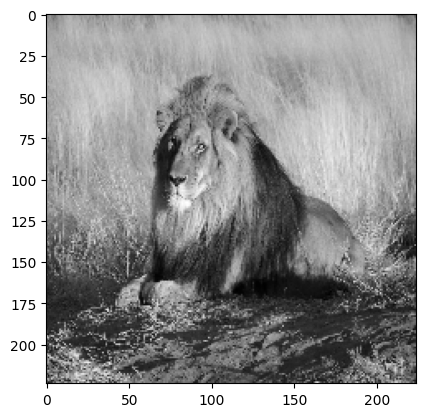

In [ ]:
test_model = tf.keras.applications.densenet.DenseNet201()
get_lion()
img_path = "lion.jpg"
input_img = prep_input(img_path)
input_img = tf.keras.applications.densenet.preprocess_input(input_img)
plt.imshow(norm_flat_image(input_img[0]), cmap = "gray")

In [ ]:
result = test_model(input_img)
max_idx = tf.argmax(result,axis = 1)
tf.keras.applications.imagenet_utils.decode_predictions(result.numpy())

[[('n02129165', 'lion', 0.9963637),
  ('n02106030', 'collie', 0.0027502126),
  ('n02105855', 'Shetland_sheepdog', 0.0004229244),
  ('n02130308', 'cheetah', 0.00014136717),
  ('n02412080', 'ram', 5.228292e-05)]]

In [ ]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,tf.float32)  * tf.cast(x>0,tf.float32) * dy
    return tf.nn.relu(x), grad

In [ ]:
count_changes = 0
layer_dict = [layer for layer in test_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu
        count_changes += 1
print(f"Updated {count_changes} layers!")

Updated 201 layers!


In [ ]:
with tf.GradientTape() as tape:
    tape.watch(input_img)
    result = test_model(input_img)
    max_score = result[0,max_idx[0]]
grads = tape.gradient(max_score, input_img)

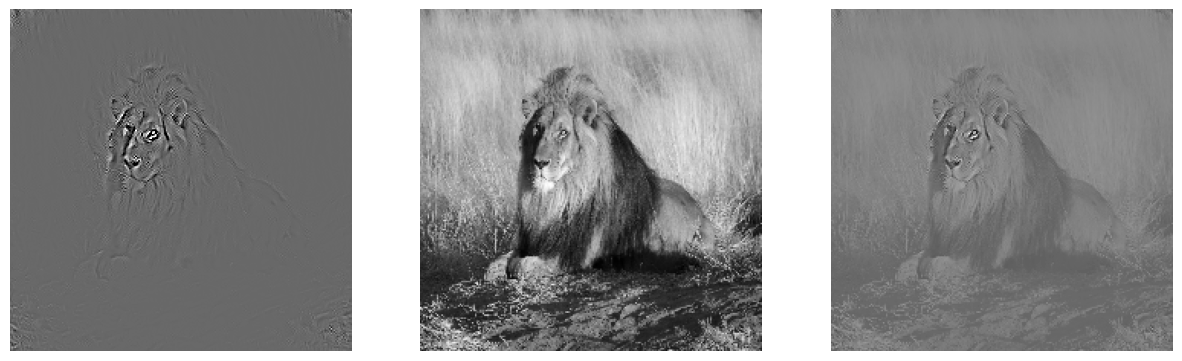

In [ ]:
plot_maps(norm_flat_image(grads[0]), norm_flat_image(input_img[0]))